In [1]:
import os
import warnings

import pandas as pd
import numpy as np

from scipy.stats import gmean
from tqdm import tqdm

from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
    get_derived_csv_path, 
    get_price_index_path
)
from jre_utils.config import asset_types

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)


def map_time_units(x):
    mapping = {
        "30-60minutes": 45,
        "1H-1H30": 75,
        "1H30-2H": 105,
        "2H-": 135,
    }

    return int(x) if x.isdigit() else mapping[x]


def map_layout(x):
    if x == "na":
        return "na"

    x = x.split("+")[0]

    if x[0].isdigit() and int(x[0]) == 1:
        if x != "1K" and x != "1LDK" and x != "1DK":
            return "1other"
        return x

    if x[0].isdigit() and int(x[0]) == 2:
        if x != "2LDK" and x != "2DK":
            return "2other"
        return x

    if x[0].isdigit() and int(x[0]) > 2:
        return f"{min(int(x[0]), 5)}LDK"

    return "other"


def map_land_shape(x):
    x = x.lower()
    x = x.replace("semi-", "")
    return x


def map_frontage(x):
    x = str(x)
    if x == "na":
        return 0
    if x == "50.0m or longer.":
        return 55
    return int(x.split(".")[0])


def map_floor_area(x):
    x = str(x)
    if "less" in x:
        return 10
    elif "greater" in x:
        return 2000
    else:
        return int(x.split(".")[0])


def map_year_of_construction(x):
    if x == "before the war":
        return 1930

    return int(x)

In [3]:
import json
from pprint import pprint

subarea_coords_simple_path = f"{DATA_DIRECTORY_PATH}/coordinates/subarea_simple.csv"
coordinates_df = pd.read_csv(subarea_coords_simple_path)
coordinates_df["area_code"] = coordinates_df["area_code"].astype(str)

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
    sub_city_to_city = json.load(fd)
    pprint(f"E.g. Maps 1101 to {sub_city_to_city['1101']}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
    area_code_to_area = json.load(fd)
    pprint(f"E.g. Maps 1100 to {area_code_to_area['1100']}")


def get_city_code(area_code):
    return sub_city_to_city.get(area_code, area_code)


def get_area_from_area_code(area_code):
    return area_code_to_area.get(area_code, "na")


'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [4]:
coordinates_df[coordinates_df['area_code'] == "12238"]

,area,area_code,subarea,long,lat
68996,Chiba-ken Isumi-shi,12238,Imazeki,140.298044,35.302627
68997,Chiba-ken Isumi-shi,12238,Iwafune,140.387774,35.207550
68998,Chiba-ken Isumi-shi,12238,Oike,140.373162,35.205629
68999,Chiba-ken Isumi-shi,12238,Ono,140.293316,35.258780
69000,Chiba-ken Isumi-shi,12238,Ohara,140.380578,35.233252
...,...,...,...,...,...
69054,Chiba-ken Isumi-shi,12238,Yaotome,140.294273,35.291040
69055,Chiba-ken Isumi-shi,12238,Shoryuji,140.260975,35.276718
69056,Chiba-ken Isumi-shi,12238,Nojitsu,140.311036,35.316693
69057,Chiba-ken Isumi-shi,12238,Misakichohigashiodaka,35.302627,140.298044


In [5]:
def process_transactions_df(df):
    df["area_code"] = df["City,Town,Ward,Village code"].astype(str)

    # we may want to skip the following step in the future
    df["area_code"] = df["area_code"].apply(get_city_code).astype(str)
    df["area"] = df["area_code"].apply(get_area_from_area_code)

    df["trade_price"] = df["Transaction-price(total)"]
    df["trade_area"] = df["Area(m^2)"].apply(area_to_int)
    df["unit_price"] = df["Transaction-price(Unit price m^2)"]
    df["trade_price_per_area"] = df["trade_price"] / df["trade_area"]

    df["quarter"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[0][0]))
    df["year"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[2]))

    df["unit_price"] = np.where(
        df["unit_price"].isna(),
        df["trade_price_per_area"],
        df["unit_price"],
    )

    df = df[
        df["Type"].isin(
            [
                asset_types["building"]["label"],
                asset_types["land"]["label"],
                asset_types["condo"]["label"],
            ],
        )
    ]

    # Renaming
    df = df.rename(
        columns={
            "Type": "asset_type",
            "Region": "neighbourhood_classification",
            "Area": "subarea",
            "Nearest stationFName": "nearest_station",
            "Nearest stationFDistance(minute)": "time_to_nearest_station",
            "Layout": "layout",
            "Land shape": "land_shape",
            "Frontage": "frontage",
            "Total floor area(m^2)": "total_floor_area",
            "Year of construction": "year_of_construction",
            "Building structure": "building_structure",
            "Use": "use",
            "Purpose of Use": "purpose",
            "Frontage roadFDirection": "frontage_road_direction",
            "Frontage roadFClassification": "frontage_road_classification",
            "Frontage roadFBreadth(m)": "frontage_road_breadth",
            "City Planning": "zone",
            "Maximus Building Coverage Ratio(%)": "max_building_coverage_ratio",
            "Maximus Floor-area Ratio(%)": "max_floor_area_ratio",
            "Renovation": "renovation_status",
            "Transactional factors": "transactional_factors",  # need to format and include
        }
    )

    # Process factors
    df["subarea"] = df["subarea"].fillna("")
    df["neighbourhood_classification"] = df["neighbourhood_classification"].fillna("na")
    df["nearest_station"] = df["nearest_station"].fillna("na")
    df["time_to_nearest_station"] = (
        df["time_to_nearest_station"].fillna("30-60minutes").apply(map_time_units)
    )
    df["layout"] = df["layout"].fillna("na").apply(map_layout)
    df["land_shape"] = df["land_shape"].fillna("na").map(map_land_shape)
    df["frontage"] = df["frontage"].fillna("na").apply(map_frontage)

    df["total_floor_area"] = np.where(
        df["total_floor_area"].isna(),
        df["trade_area"].astype(str),
        df["total_floor_area"],
    )

    df["total_floor_area"] = df["total_floor_area"].apply(map_floor_area)

    df["year_of_construction"] = np.where(
        df["year_of_construction"].isna(),
        (df["year"] - 30).astype(str),
        df["year_of_construction"],
    )

    df["year_of_construction"] = df["year_of_construction"].apply(
        map_year_of_construction
    )
    df["age"] = (df["year"] - df["year_of_construction"]).apply(lambda x: max(x, 0))

    df["building_structure"] = df["building_structure"].fillna("na")
    df["frontage_road_direction"] = df["frontage_road_direction"].fillna("na")
    df["frontage_road_classification"] = df["frontage_road_classification"].fillna("na")
    df["frontage_road_breadth"] = (
        df["frontage_road_breadth"].fillna("0.0").astype(float)
    )
    df["zone"] = df["zone"].fillna("na")
    df["max_building_coverage_ratio"] = df["max_building_coverage_ratio"].fillna(0)
    df["max_floor_area_ratio"] = df["max_floor_area_ratio"].fillna(0)
    df["renovation_status"] = df["renovation_status"].fillna("na")

    df["use"] = df["use"].fillna("na")
    df["purpose"] = df["purpose"].fillna("na")
    df["transactional_factors"] = df["transactional_factors"].fillna("na")

    df = df.drop(
        columns=[
            "City,Town,Ward,Village code",
            "City,Town,Ward,Village",
            "Transaction-price(total)",
            "Area(m^2)",
            "Transaction-price(Unit price m^2)",
            "trade_price_per_area",
            "Transaction period",
            "Prefecture",
        ]
    )

    df = df.merge(coordinates_df, on=["area", "area_code", "subarea"], how="left")

    return df

In [6]:
def custom_aggregate(x):
    d = {}
    d["unit_price_median"] = x["unit_price"].median()
    d["unit_price_gmean"] = gmean(x["unit_price"])
    d["count"] = x["count"].count()
    return pd.Series(
        d,
        index=[
            "unit_price_median",
            "unit_price_gmean",
            "count",
        ],
    )


def filter_df(df):
    return df[
        (df["Region"] != "Industrial Area")
        & (
            ~df["Use"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
        & (
            ~df["Purpose of Use"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
    ]

In [7]:
id_columns = ["year"]
metric_columns = ["unit_price_log"]

id_columns = ["year"]
metric_columns = ["unit_price_log"]

# land_df.info()

land_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ],
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "transactional_factors",
    ],
}

# building_df.info()

building_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "total_floor_area",
        "trade_area",
        "age",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ],
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

# condo_df.info()

condo_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "age",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ],
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "renovation_status",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

columns_dicts = {
    "land": land_columns,
    "building": building_columns,
    "condo": condo_columns,
}

In [8]:
def get_price_index_from_regression(regression_results, prefix=""):
    yearly_results = regression_results.params.filter(like="year_")
    yearly_results = yearly_results.apply(lambda x: np.exp(x))
    base_year = min(yearly_results.index)
    base_coef = yearly_results[base_year]
    yearly_results = yearly_results / base_coef * 100

    yearly_results.name = f"{prefix}price_index"

    yearly_p_value = regression_results.pvalues.filter(like="year_")
    yearly_p_value.name = f"{prefix}p_value"

    yearly_weights = regression_results.tvalues.filter(like="year_")
    yearly_weights = np.abs(yearly_weights).apply(lambda x: max(min(x, 20), 0.2)) + 1
    yearly_weights.name = f"{prefix}weights"

    results_df = pd.concat([yearly_results, yearly_p_value, yearly_weights], axis=1)
    results_df = results_df.reset_index().rename(columns={"index": "year"})
    results_df["year"] = results_df["year"].apply(lambda x: x.split("_")[1])
    return results_df

def calculate_price_index(area_df, columns_dict):
    numerical_columns = columns_dict["numerical_columns"]
    categorical_columns = columns_dict["categorical_columns"]
    comma_separated_categorical_columns = columns_dict[
        "comma_separated_categorical_columns"
    ]
    all_unprocessed_columns = (
        numerical_columns + categorical_columns + comma_separated_categorical_columns
    )

    area_df["year"] = area_df["year"].astype(str)
    area_df["quarter"] = area_df["quarter"].astype(str)
    area_df[f"unit_price_log"] = np.log(area_df["unit_price"])

    # Numerical variables
    scaler = StandardScaler()

    for column in numerical_columns:
        area_df[column] = area_df[column].fillna(area_df[column].mean())
        area_df[column] = np.log(area_df[column] + 1)

    area_df[numerical_columns] = scaler.fit_transform(area_df[numerical_columns])

    # Categorical variables
    area_df = pd.get_dummies(
        area_df[all_unprocessed_columns + id_columns + metric_columns],
        columns=categorical_columns,
    )

    # Comma Separated Categorical variables
    for column in comma_separated_categorical_columns:
        one_hot_df = (
            area_df[column]
            .str.replace(" ", "")
            .str.get_dummies(sep=",")
            .rename(columns=lambda x: column + x)
        )
        area_df = pd.concat([area_df, one_hot_df], axis=1)
        area_df = area_df.drop(columns=[column])

    drop_columns = [col for col in area_df.columns if "na" in col]
    area_df = area_df.drop(columns=drop_columns)

    # Model
    X_ord = area_df.drop(columns=id_columns + metric_columns)

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain p% of the variance
    X_pca = pca.fit_transform(X_ord)

    # Expand years
    yearly_df = area_df[id_columns + metric_columns]
    yearly_df = pd.get_dummies(yearly_df, columns=id_columns, drop_first=True)
    yearly_df = pd.concat(
        [
            yearly_df,
            pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)]),
        ],
        axis=1,
    )

    X = yearly_df.drop(columns=metric_columns)
    y = yearly_df[metric_columns[0]]

    # Add a constant to the model (the intercept)
    X = sm.add_constant(X)

    # Fit the OLS model
    ordinary_results = sm.OLS(y, X).fit()
    robust_results = sm.RLM(y, X).fit()

    # Compile results
    ordinary_results_df = get_price_index_from_regression(
        ordinary_results, prefix="ols_"
    ).sort_values("year")

    robust_results_df = get_price_index_from_regression(
        robust_results, prefix="robust_"
    ).sort_values("year")

    return ordinary_results_df, robust_results_df

In [9]:
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in os.listdir(trade_prices_data_path)
]

In [10]:
def is_contiguous(arr):
    sorted_arr = sorted(arr)
    return all((y2 - y1) == 1 for y1, y2 in zip(sorted_arr, sorted_arr[1:]))

def is_up_to_date(years, end_year):
    return max(years) == end_year

def is_valid_area_df(years_count_dict, end_year):
    years = [int(year) for year, count in years_count_dict.items() if count > 3]
    return len(years) > 8 and is_contiguous(years) and is_up_to_date(years, end_year)


In [16]:
derived_dfs = {
    "land": pd.DataFrame(),
    "building": pd.DataFrame(),
    "condo": pd.DataFrame(),
}

final_year = 2022

skipped_areas = []

pbar = tqdm(total=len(trade_prices_data_paths))

for path in trade_prices_data_paths:
    main_df = pd.read_csv(path, encoding="unicode_escape", index_col="No")
    main_df = process_transactions_df(main_df.copy())
    main_df = main_df.assign(count=1)

    for asset_type, asset_type_props in asset_types.items():
        df = main_df[main_df["asset_type"] == asset_type_props["label"]]
        df = df[df["year"] <= final_year]
        prefecture_df = pd.DataFrame()

        for area_code in df["area_code"].unique():
            area_df = df[df["area_code"] == area_code].reset_index(drop=True)
            if is_valid_area_df(area_df["year"].value_counts().to_dict(), final_year):
                area_df["year"] = area_df["year"].astype(str)
                ordinary_results_df, robust_results_df = calculate_price_index(
                    area_df.copy(), columns_dicts[asset_type]
                )
                aggregate_results_df = area_df.groupby("year").apply(custom_aggregate)
                
                results_df = robust_results_df.merge(
                    ordinary_results_df, on="year"
                ).merge(aggregate_results_df, on="year")

                # results_df = pd.concat([ordinary_results_df, robust_results_df], axis=1)
                results_df["area_code"] = area_code
                results_df["area"] = area_df["area"].iloc[0]

                results_df = results_df.sort_values(
                    by=["year", "area_code"], ascending=[False, True]
                ).reset_index(drop=True)

                prefecture_df = pd.concat([prefecture_df, results_df], axis=0)
            else:
                skipped_areas.append(area_code)

        derived_dfs[asset_type] = pd.concat([derived_dfs[asset_type], prefecture_df])

    pbar.update()

pbar.close()

100%|██████████| 47/47 [16:36<00:00, 21.21s/it]


In [17]:
PRICE_INDEX_DATA_PATH = f"{DATA_DIRECTORY_PATH}/derived/price_index"
def get_price_index_path(asset_type):
    filename = f"{asset_type}.csv"
    return f"{PRICE_INDEX_DATA_PATH}/{filename}"

In [18]:
# Save derived dataframes
for asset_type, asset_type_props in asset_types.items():
    path = get_price_index_path(
        asset_type,
    )
    derived_dfs[asset_type].to_csv(
        path,
        index=False,
    )
    print(f"Wrote to {path}")

Wrote to ../../data/derived/price_index/land.csv
Wrote to ../../data/derived/price_index/building.csv
Wrote to ../../data/derived/price_index/condo.csv


In [26]:
path = get_price_index_path(
    "land"
)
df = pd.read_csv(path)
df

,year,robust_price_index,robust_p_value,robust_weights,ols_price_index,ols_p_value,ols_weights,unit_price_median,unit_price_gmean,count,area_code,area
0,2022,85.235362,1.302209e-08,6.685775,78.637005,5.816867e-10,7.204766,48500.0,41788.857287,350.0,30201,Wakayama-ken Wakayama-shi
1,2021,82.760900,6.255441e-11,7.537503,73.146201,1.623671e-14,8.695226,50000.0,38566.617539,435.0,30201,Wakayama-ken Wakayama-shi
2,2020,85.235192,1.759634e-09,7.018571,79.463180,1.794825e-10,7.388241,55000.0,41190.968402,450.0,30201,Wakayama-ken Wakayama-shi
3,2019,90.245932,1.160665e-06,5.862237,85.742543,3.050797e-07,6.125678,53000.0,41869.277162,455.0,30201,Wakayama-ken Wakayama-shi
4,2018,81.807183,2.166274e-12,8.023339,78.813228,2.857342e-11,7.665413,50000.0,40587.619348,479.0,30201,Wakayama-ken Wakayama-shi
...,...,...,...,...,...,...,...,...,...,...,...,...
18704,2012,78.624223,3.647150e-01,1.906417,72.593673,1.952208e-01,2.300944,23000.0,19214.114400,9.0,36489,Tokushima-ken Higashimiyoshi-cho
18705,2011,48.249177,7.239751e-04,4.380335,48.151321,1.202374e-03,4.299740,14000.0,10479.419711,11.0,36489,Tokushima-ken Higashimiyoshi-cho
18706,2010,89.941317,7.102464e-01,1.371525,91.142013,6.648581e-01,1.434052,23500.0,22140.037092,16.0,36489,Tokushima-ken Higashimiyoshi-cho
18707,2009,86.861335,5.784126e-01,1.555705,87.043220,5.099030e-01,1.660526,17000.0,21356.316363,17.0,36489,Tokushima-ken Higashimiyoshi-cho


In [20]:
test_area = 13103 # Tokyo-to Chuo-ku


In [22]:
area_df = df[df["area_code"] == test_area][["year", "area_code", "area", "robust_price_index"]]
area_df["yearly_price_change"] = area_df["robust_price_index"].pct_change()
# area_df.round(2).to_csv("test.csv", index=False)
area_df

,year,area_code,area,robust_price_index,yearly_price_change
1453,2022,13103,Tokyo-to Minato-ku,166.268835,NaN
1454,2021,13103,Tokyo-to Minato-ku,162.153557,-0.024751
1455,2020,13103,Tokyo-to Minato-ku,141.519885,-0.127248
1456,2019,13103,Tokyo-to Minato-ku,137.026998,-0.031747
1457,2018,13103,Tokyo-to Minato-ku,139.998216,0.021683
1458,2017,13103,Tokyo-to Minato-ku,133.281019,-0.047981
1459,2016,13103,Tokyo-to Minato-ku,112.024271,-0.159488
1460,2015,13103,Tokyo-to Minato-ku,97.240836,-0.131966
1461,2014,13103,Tokyo-to Minato-ku,94.609392,-0.027061
1462,2013,13103,Tokyo-to Minato-ku,82.045456,-0.132798


<Axes: xlabel='year'>

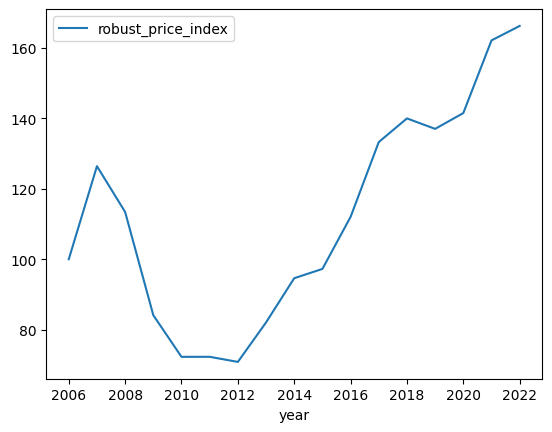

In [23]:
# gmean
df[df["area_code"] == test_area].plot(x="year", y="robust_price_index")